In [0]:
!https://github.com/bearpaw/clothing-co-parsing.git

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import scipy.io as scipyio
import os
from keras.utils import to_categorical
from tqdm import tqdm

In [0]:
Height = 256
Width = 256

cwd = os.getcwd()
ori_data_dir = "/clothing-co-parsing"
img_path = cwd + ori_data_dir + "/photos"
mask_mat_path = cwd + ori_data_dir +"/annotations/pixel-level"

img_list = [img for img in sorted(os.listdir(img_path)) if os.path.splitext(img)[1] == '.jpg']
mask_mat_list =  [mask for mask in sorted(os.listdir(mask_mat_path)) if os.path.splitext(mask)[1] == '.mat']

In [0]:
def create_img_dataset(img_list, height, width):
    
    img_data = np.zeros((len(img_list), height, width, 3), dtype = np.uint8)
    
    for i, img in enumerate(img_list):
        img = cv2.imread(img_path + "/" + img)
        img = cv2.resize(img, dsize=(width,height), interpolation = cv2.INTER_NEAREST)
        img_data[i] = img
        
    print("Creating image dataset sucessfully")
    return img_data

In [0]:
mask_img_dir = cwd + ori_data_dir + '/mask_image/'

def create_mask_dataset(mask_mat_list, height, width):
    
    mask_data = np.zeros((len(mask_mat_list), height, width, 1), dtype = np.uint8)
    
    if not os.path.exists(mask_img_dir):
        os.makedirs(mask_img_dir)

    for i, mask_mat in enumerate(mask_mat_list):
        mask = scipyio.loadmat(mask_mat_path + "/" + mask_mat)["groundtruth"]
        mask = cv2.resize(mask, dsize=(width,height), interpolation = cv2.INTER_NEAREST)
        mask_data[i] = mask.reshape(height,width,1)
     
    
    print("Transforming mask .mat files to resized .png amd creating mask dataset sucessfully")
    return mask_data

In [0]:
img_data = create_img_dataset(img_list, Height, Width)

In [0]:
mask_data = create_mask_dataset(mask_mat_list, Height, Width)

In [0]:
def mask_data_to_show(mask_data, height, width):
    
    return mask_data.reshape(height, width)

In [0]:
def labelize(mask_data):
    data_size = mask_data.shape[0]
    mask_data = mask_data.reshape(data_size, -1)
    labelize_mask_data = np.zeros(mask_data.shape)
    
    for i in tqdm(range(data_size)):
        
        for j, pixel in enumerate(mask_data[i]):
                    
            
            if pixel == 0 :
                labelize_mask_data[i][j] = 0 # background
            elif pixel == 19:
                labelize_mask_data[i][j] = 2 # hair
            elif pixel == 41:
                labelize_mask_data[i][j] = 1 # skin
            else:
                labelize_mask_data[i][j] = 3 # clothes
                
    label_data = labelize_mask_data.reshape(-1, Height, Width, 1)
    
    return label_data

In [0]:
label_data = labelize(mask_data)
print(label_data.shape)

(1004, 256, 256, 1)


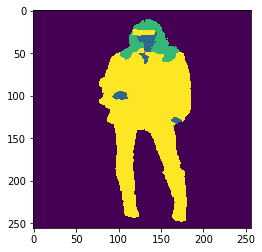

In [0]:
print(label_data.reshape(-1, Height, Width, 1).shape)
label = label_data.reshape(-1, Height, Width, 1)[2]
plt.imshow(np.squeeze(label))

In [0]:
data_path = cwd + '/data/'

# Reference: https://keras.io/utils/
def save_dataset(img_data, label_data):
    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    one_hot_label_data = to_categorical(label_data, 4)
    
    np.save(data_path + 'img_train.npy', img_data[:880])
    np.save(data_path + 'one_hot_label_train.npy', one_hot_label_data[:880])
    np.save(data_path + 'img_test.npy', img_data[880:1004])
    np.save(data_path + 'one_hot_label_test.npy', one_hot_label_data[880:1004])

In [0]:
save_dataset(img_data, label_data)

In [0]:
def load_dataset():
    
    npy_list = os.listdir(data_path)
    
    for i in npy_list:
        if not os.path.exists(data_path + i):
            print("No saved dataset, saving dataset now")
            save_dataset(img_data, mask_data)
            break
    
    img_train = np.load('data/img_train.npy').astype(np.float32)
    mask_train = np.load('data/one_hot_label_train.npy').astype(np.float32)
    img_test = np.load('data/img_test.npy').astype(np.float32)
    mask_test = np.load('data/one_hot_label_test.npy').astype(np.float32)
    
    return img_train, mask_train, img_test, mask_test

In [0]:
img_train, mask_train, img_test, mask_test = load_dataset()